# Plot global mean temperatures from CMIP models (no neural networks here)
##### authors: Elizabeth A. Barnes and Noah Diffenbaugh
##### date: March 21, 2022


## Python stuff

In [1]:
import sys, imp, os, copy

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import tensorflow_probability as tfp

import cartopy as ct
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import scipy.stats as stats
import seaborn as sns

import experiment_settings
import file_methods, plots, data_processing

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")  
print(f"tensorflow version = {tf.__version__}")  
print(f"tensorflow-probability version = {tfp.__version__}")  

python version = 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:27:43) 
[Clang 11.1.0 ]
numpy version = 1.22.2
xarray version = 2022.3.0
tensorflow version = 2.7.0
tensorflow-probability version = 0.15.0


## User Choices

In [3]:
EXP_NAME = 'exp14' #exp14,exp0
PLOT_SEED = 1257

#-------------------------------------------------------

settings = experiment_settings.get_settings(EXP_NAME)
display(settings)

MODEL_DIRECTORY = 'saved_models/'        
PREDICTIONS_DIRECTORY = 'saved_predictions/'
DATA_DIRECTORY = 'data/'
DIAGNOSTICS_DIRECTORY = 'model_diagnostics/'
FIGURE_DIRECTORY = 'figures/'

{'save_model': True,
 'n_models': 10,
 'ssp': '126',
 'gcmsub': 'UNIFORM',
 'obsdata': 'BEST',
 'target_temp': 1.5,
 'n_train_val_test': (7, 2, 1),
 'baseline_yr_bounds': (1850, 1899),
 'training_yr_bounds': (1970, 2100),
 'anomaly_yr_bounds': (1951, 1980),
 'anomalies': True,
 'remove_map_mean': False,
 'network_type': 'shash2',
 'hiddens': [10, 10],
 'dropout_rate': 0.0,
 'ridge_param': [1.0, 0.0],
 'learning_rate': 1e-05,
 'batch_size': 64,
 'rng_seed': 8889,
 'seed': None,
 'act_fun': ['relu', 'relu'],
 'n_epochs': 25000,
 'patience': 50,
 'exp_name': 'exp14'}

## Plotting Functions

In [4]:
FS = 10

### for white background...
# plt.rc('text',usetex=True)
plt.rc('text',usetex=False)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

## Load observations

In [5]:
# load observations for diagnostics plotting
da_obs, x_obs, global_mean_obs = data_processing.get_observations(DATA_DIRECTORY, settings)
N_TRAIN, N_VAL, N_TEST, ALL_MEMBERS = data_processing.get_members(settings)

observations: filling NaNs with zeros
np.shape(x_obs) = (172, 10368)


## Plot CMIP Timeseries

tas_Amon_historical_ssp126_CanESM5_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2011
tas_Amon_historical_ssp126_ACCESS-ESM1-5_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2032
tas_Amon_historical_ssp126_UKESM1-0-LL_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2024
tas_Amon_historical_ssp126_MIROC-ES2L_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2034


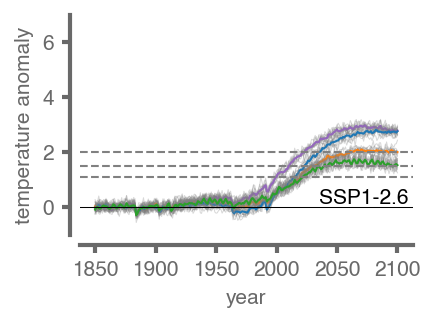

In [6]:
rng = np.random.default_rng(settings["rng_seed"])
settings["seed"] = PLOT_SEED

## determine how many GCMs are being used
filenames = file_methods.get_cmip_filenames(settings, verbose=0)
N_GCMS = len(filenames)

# loop through the models and plot
clr = ('tab:purple','tab:orange', 'tab:blue', 'tab:green', 'gold', 'brown','black','darkorange')
fig,axs = plt.subplots(1,1,figsize=(3,2.25))

for imodel, f in enumerate(filenames):
    print(f)
    da = file_methods.get_netcdf_da(DATA_DIRECTORY + f)
    f_labels, f_years, f_target_year = data_processing.get_labels(da, settings,)

    # compute global mean
    global_mean = data_processing.compute_global_mean(da)
    baseline_mean = global_mean.sel(time=slice(str(settings["baseline_yr_bounds"][0]),str(settings["baseline_yr_bounds"][1]))).mean('time')
    global_mean_anomalies = global_mean - baseline_mean
    
    # plot the members
    plt.plot(f_years, 
             np.swapaxes(global_mean_anomalies.to_numpy(),1,0), 
             color='gray',
             linewidth=.5,
             alpha=.3,
            )
    # plot ensemble mean
    plt.plot(f_years, 
             np.mean(global_mean_anomalies,axis=0), 
             color=clr[imodel],
             linewidth=1.,
             alpha=1.,
            )
    
# plt.title('Global Mean Temperatures for SSP'+ str(settings["ssp"]),fontsize=12)
plt.xlabel('year',fontsize=FS)
plt.ylabel('temperature anomaly',fontsize=FS)
plt.xticks(np.arange(1850,2150,50),np.arange(1850,2150,50))

plt.ylim(-1,7)
plt.axhline(y=0, color='black', linewidth=0.5)
plt.axhline(y=1.1, color='gray', linewidth=1.0, linestyle='--')
plt.axhline(y=1.5, color='gray', linewidth=1.0, linestyle='--')
plt.axhline(y=2.0, color='gray', linewidth=1.0, linestyle='--')

plt.text(2035,
         0,
         "SSP" + settings["ssp"][0] + '-' + settings["ssp"][1] + '.' + settings["ssp"][-1],
         fontsize=FS,
         horizontalalignment="left",
         verticalalignment="bottom",
         color='k', 
         weight="bold",
        )

format_spines(plt.gca())

plt.tight_layout()
plt.savefig(FIGURE_DIRECTORY + settings["exp_name"] + '_cmip_gmt' + '.png', 
            bbox_inches="tight",
            dpi=savefig_dpi)
plt.show()    
    



## Plot CMIP Maps

In [7]:
from matplotlib import cm
newcmap = pd.read_csv(DATA_DIRECTORY + "blue_dark_red_18_colormap.csv").to_numpy()
newcmap = np.delete(newcmap,9,0)
newcmap = ListedColormap(newcmap/256.)
map_proj = ct.crs.EqualEarth(central_longitude = 0.)


tas_Amon_historical_ssp126_CanESM5_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2011
tas_Amon_historical_ssp126_MIROC-ES2L_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2034


/var/folders/4v/ts3652896rl6syn3f_jmnsvh0001zl/T/ipykernel_33248/1223735620.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


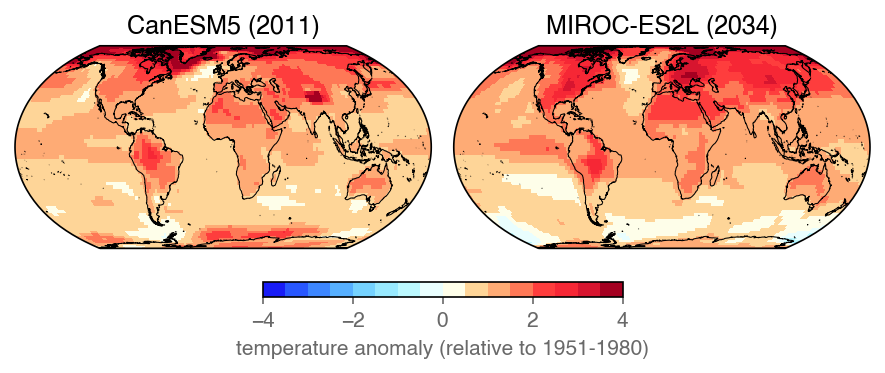

In [8]:
rng = np.random.default_rng(settings["rng_seed"])
settings["seed"] = PLOT_SEED

## determine how many GCMs are being used
filenames = file_methods.get_cmip_filenames(settings, verbose=0)
N_GCMS = len(filenames)

# loop through the models and plot
clr = ('tab:purple','tab:orange', 'tab:blue', 'tab:green', 'gold', 'brown','black','darkorange')
fig = plt.figure(figsize=(6,2))

for imodel, f in enumerate(filenames):
    
    if f.find('CanESM5')>-1:
        ipanel = 1
        cmip_name = 'CanESM5'
    elif f.find('MIROC-ES2L')>-1:
        ipanel = 2        
        cmip_name = 'MIROC-ES2L'
    else:
        continue
    
    print(f)
    da = file_methods.get_netcdf_da(DATA_DIRECTORY + f)
    da = data_processing.preprocess_data(da,None,settings)
    f_labels, f_years, f_target_year = data_processing.get_labels(da, settings,)

    iplot = np.where(da["time.year"]==f_target_year)[0]

    ax = fig.add_subplot(1,2,ipanel,projection=map_proj)
    cb,image = plots.drawOnGlobe(ax, 
                      map_proj, 
                      data=np.squeeze(np.mean(da[:,iplot,:,:],axis=0)), 
                      lats=da_obs['lat'], 
                      lons=da_obs['lon'], 
                      cmap=newcmap,
                      vmin= -4., 
                      vmax= 4., 
                      inc=None, 
                      cbarBool=False, 
                      contourMap=[], 
                      contourVals = [], 
                      fastBool=True, 
                      extent='both',
                     )
    ax.set_title(cmip_name + ' (' + str(f_target_year) + ')',fontsize=FS*1.2)
    
fig.subplots_adjust(bottom=0.05)
cbar_ax = fig.add_axes([0.3, 0.0, 0.4, 0.05])
cbar = fig.colorbar(image, cax=cbar_ax, orientation='horizontal')
cbar.set_label('temperature anomaly (relative to 1951-1980)',fontsize=FS*1.)
# cbar.set_ticks((-3,-1.5,0,1.5,3))


plt.tight_layout()
plt.savefig(FIGURE_DIRECTORY + settings["exp_name"] + '_cmip_CanESM5_MIROC_ES2L_maps' + '.png', 
            bbox_inches="tight",
            dpi=savefig_dpi)
plt.show()    
    



## Plot observed temperature maps

/var/folders/4v/ts3652896rl6syn3f_jmnsvh0001zl/T/ipykernel_33248/986957531.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


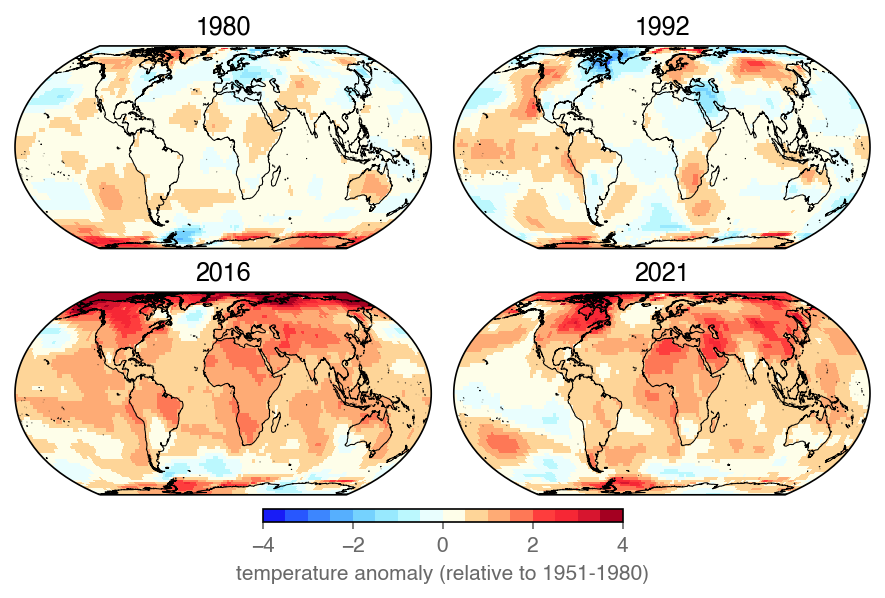

In [9]:
imp.reload(plots)

fig = plt.figure(figsize=(6,3.5))

for iloop,year in enumerate((1980, 1992, 2016, 2021)):
    iplot = np.where(da_obs["time.year"]==year)[0]
    
    ax = fig.add_subplot(2,2,iloop+1,projection=map_proj)
    cb,image = plots.drawOnGlobe(ax, 
                      map_proj, 
                      data=np.squeeze(da_obs[iplot,:,:]), 
                      lats=da_obs['lat'], 
                      lons=da_obs['lon'], 
                      cmap=newcmap,
                      vmin= -4., 
                      vmax= 4., 
                      inc=None, 
                      cbarBool=False, 
                      contourMap=[], 
                      contourVals = [], 
                      fastBool=True, 
                      extent='both',
                     )
    ax.set_title(str(year),fontsize=FS*1.2)
    
fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.3, 0.0, 0.4, 0.025])
cbar = fig.colorbar(image, cax=cbar_ax, orientation='horizontal')
cbar.set_label('temperature anomaly (relative to 1951-1980)',fontsize=FS)
# cbar.set_ticks((-3,-1.5,0,1.5,3))

plt.tight_layout()    
plt.savefig(FIGURE_DIRECTORY + 'obs_temperature_maps.png', 
            dpi=savefig_dpi,
            bbox_inches="tight",
           )
plt.show()